In [201]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib

Mount personal Google Drive folder

In [202]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Use furniture dataset provided in the previous lab

In [203]:
df = pd.read_csv('/content/gdrive/MyDrive/Links Accademy - AI/2. Time series analysis/data/furniture.csv')
df

,Order Date,Sales
0,2014-01-01,480.194231
1,2014-02-01,367.931600
2,2014-03-01,857.291529
3,2014-04-01,567.488357
4,2014-05-01,432.049188
5,2014-06-01,695.059242
6,2014-07-01,601.169500
7,2014-08-01,457.521656
8,2014-09-01,992.353367
9,2014-10-01,769.015437


In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Order Date  48 non-null     object 
 1   Sales       48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 896.0+ bytes


Data preprocessing: set right data types and index

In [205]:
df['Order Date']=pd.to_datetime(df['Order Date'])
df = df.set_index('Order Date')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2014-01-01 to 2017-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


Create a method called "check_stazionarity". Use adfuller from statsmodels.tsa.stattools ([link](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html))

In [206]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, signif=0.05, name='', verbose=False):


    result = adfuller(series.values)
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

Call "check_stazionarity" and test furniture dataset

In [207]:
check_stationarity(df['Sales'])

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
ADF Statistic: -5.191070
p-value: 0.000009
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610
Stationary


## ARIMA/SARIMA hyperparameters tuning

Select a range(0,2) for the three ARIMA params -> p, d, q and get all possible permutations. Eg: (0,0,0)... (1,1,1).

Tips: use itertools

In [208]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

In [209]:
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


- For each element in pdq and seasonal_pdq train a SARIMAX model.
- Calculate the best one considering its AIC (Akaike Information Criterion).
- Save the parameters combination and AIC in a list of lists

In [210]:
import statsmodels.api as sm

results_aic = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
      mod = sm.tsa.statespace.SARIMAX(df,
                                order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
      results = mod.fit()
      results_aic.append([param, param_seasonal, results.aic])
      # print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Li

From the list of all params combinations with AIC choose the params with minor AIC.

Tips: use an numpy array and numpy.where function

In [211]:
results_aic = np.array(results_aic)

best_par_index = np.where(results_aic[:, 2] == results_aic[:, 2].min())
best_par = results_aic[best_par_index].reshape(-1)

<ipython-input-211-61471bc1f41f>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results_aic = np.array(results_aic)


In [212]:
best_par

array([(0, 1, 1), (0, 1, 1, 12), 279.58062334013965], dtype=object)

Finally use the best combination to train a Sarimax model

In [213]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=best_par[0],
                                seasonal_order=best_par[1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
results.aic

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


279.58062334013965

In [214]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -136.790
Date:                            Wed, 25 Oct 2023   AIC                            279.581
Time:                                    15:01:10   BIC                            282.714
Sample:                                01-01-2014   HQIC                           280.261
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000   3861.999     -0.000      1.000   -7570.379    7568.379
ma.S.L12      -3.2469      1.660     -1.956      0.050      -6.501       0.007
sigma2      2368.6961   9.15e+06      0.000      1.000   -1.79e+07    1.79e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                 0.71
Prob(Q):                              0.63   Prob(JB):                         0.70
Heteroskedasticity (H):               0.79   Skew:                            -0.21
Prob(H) (two-sided):                  0.76   Kurtosis:                         2.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

  ### Model Specification (Model):
  - The SARIMAX model is specified as SARIMAX(0, 1, 1)x(0, 1, 1, 12).
  The numbers in the parentheses represent the order of the Seasonal AutoRegressive (AR), Integrated (I), and Moving Average (MA) components of the model, both for the non-seasonal part and the seasonal part.
  In this case, the non-seasonal part doesn't have AR or seasonal components, but it has a first-order moving average component (ma.L1).
  The seasonal part has a seasonal moving average component (ma.S.L12) with a seasonal period of 12.

- Log Likelihood:

  - The log likelihood of the model is -136.790.

- Information Criteria:

  - The Akaike Information Criterion (AIC) is 279.581.
  - The Bayesian Information Criterion (BIC) is 282.714.
  - The Hannan-Quinn Information Criterion (HQIC) is 280.261.

- Sample Period:

  - The data spans from January 1, 2014, to December 1, 2017.

- Covariance Type:

  - The covariance type used for estimating standard errors is "opg" (Outer Product of the Gradient).

- Coefficient Statistics:

  - For each coefficient in the model (e.g., ma.L1, ma.S.L12), the summary provides information about the coefficient value (coef), standard error (std err), z-statistic (z), p-value (P>|z|), and the 95% confidence interval ([0.025, 0.975]).

- Variance of Residuals (sigma2):

  - The estimated variance of the model residuals is 2368.6961.

## Model Diagnostics:

  - The summary includes some diagnostic statistics:
      - Ljung-Box (Q): A test of autocorrelation in the residuals at lag 1. The value is 0.23.
      - Jarque-Bera (JB): A test of the normality of the residuals. The value is 0.71.
      - Prob(Q): The p-value for the Ljung-Box test is 0.63.
      - Prob(JB): The p-value for the Jarque-Bera test is 0.70.

- Heteroskedasticity and Skewness:

    - Heteroskedasticity (H): A measure of heteroskedasticity in the residuals. The value is 0.79.
    - Skew: A measure of skewness in the residuals. The value is -0.21.

- Prob(H) and Kurtosis:

    - Prob(H) (two-sided): The p-value for the test of heteroskedasticity is 0.76.
    - Kurtosis: A measure of the peakedness of the distribution of residuals. The value is 2.20.

## Predictions

1. Take readings from January 2017 to the end and make prediction
2. Calculate confidential interval of predictions
3. Plot full data, predicitons from January 2023 and confidential interval

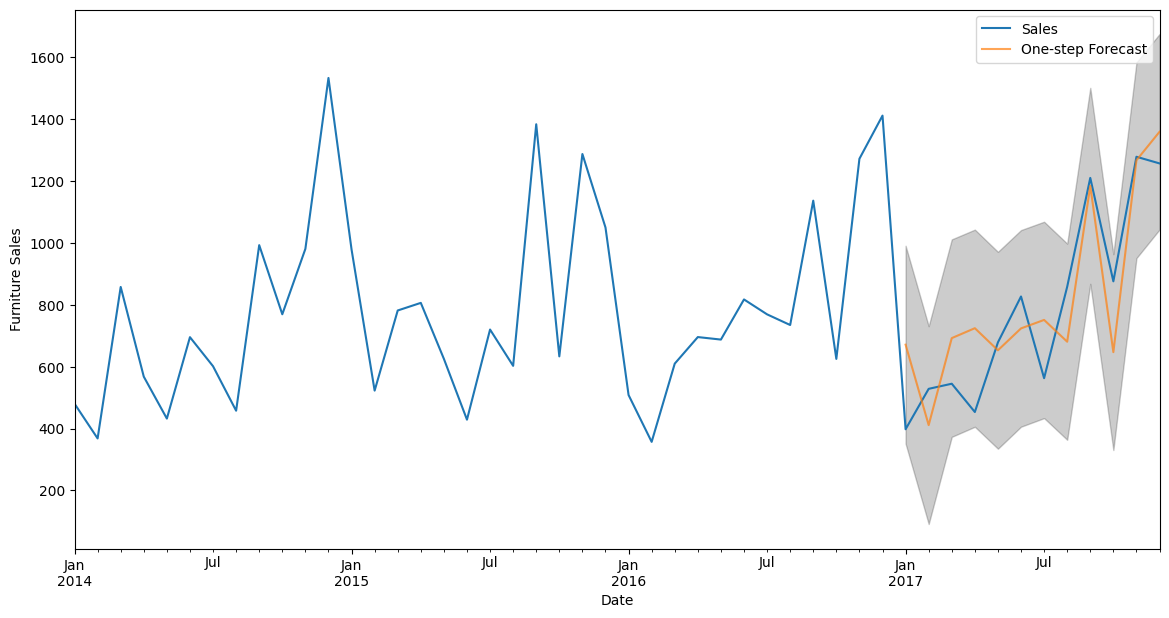

In [215]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int() # confidential interval

ax = df['2014':].plot(label='observed') ## plotting real data
pred.predicted_mean.plot(ax=ax, label='One-step Forecast', alpha=.7, figsize=(14, 7)) ## plotting predicted data
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2) ## plotting confidential interval

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

## Evaluation

Take predictions and real values from January 2017

In [216]:
y_forecasted = pred.predicted_mean
y_truth = df['2017-01-01':].squeeze()

Calculate mean squared error of predictions

MSE = $\frac{1}{n} \Sigma_{i=1}^n({y}-\hat{y})^2$

In [217]:
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 27090.5


Calculate root mean squared error of predictions

RMSE = $\sqrt{\frac{1}{n} \Sigma_{i=1}^n({y}-\hat{y})^2}$

In [218]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 164.59


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 164.59 of the real sales. Our furniture daily sales range from around 400 to over 1200. This is a pretty good model so far!

## Forecasting

As done previously, but make predictions on previously unseen data.

Then plot full data, predicitons on unseen data and confidential interval.


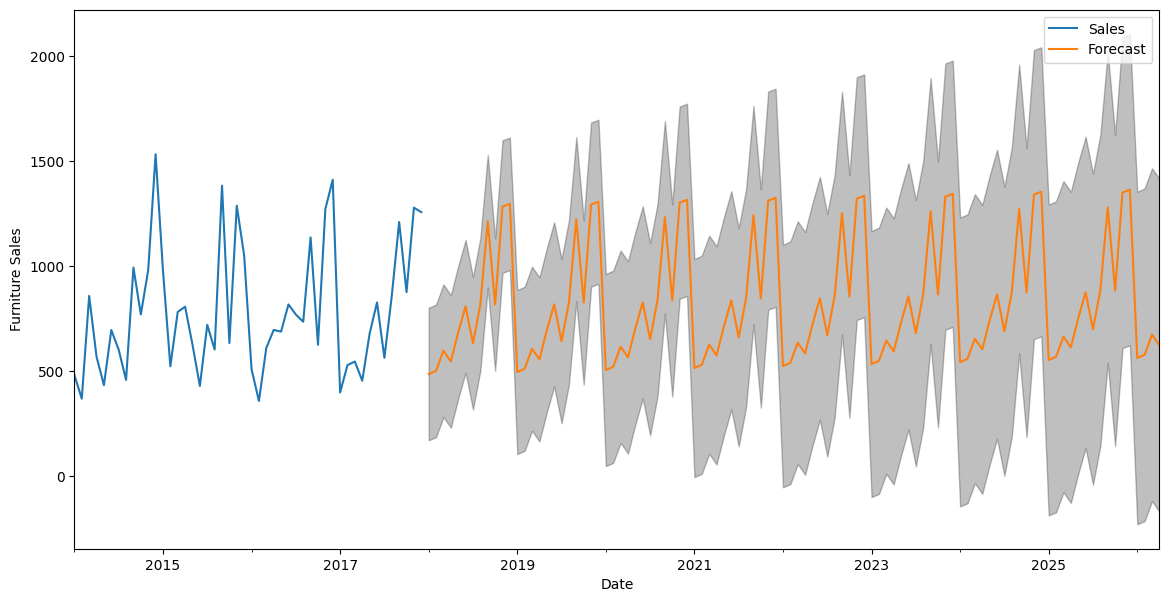

In [219]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = df.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

Our model clearly captured furniture sales seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.